# Machine Learning Template


In [133]:
import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from src.ml_template import utils

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import shap

import xgboost as xgb

import seaborn as sns



In [262]:
features = pd.read_csv(r"\\umweltbundesamt.at\Projekte\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\2025_26_Auswertung_C_H2O_Duerre\Ergebnisse\predictors_daily.txt", sep=';', parse_dates=True)
rproc = pd.read_csv(r"\\umweltbundesamt.at\Projekte\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\0000_EddyKovarianz\NEE_Partitioning\nee-partitioning\results\EddyProc\NEEpart.csv", parse_dates=True)
fsv_partitioned = glob.glob(r"\\umweltbundesamt.at\Projekte\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\0000_EddyKovarianz\NEE_Partitioning\nee-partitioning\results\fluxpart\fvs_partitioned_30min_*.txt")
fvs_partition_df = pd.concat([pd.read_csv(file, sep=';', parse_dates=['datetime']) for file in fsv_partitioned])

In [203]:
rproc = rproc[["GPP_DT", "Reco_DT"]].groupby(pd.to_datetime(rproc.datetime).dt.date).mean()

AttributeError: 'DataFrame' object has no attribute 'datetime'

In [204]:
fluxpart = fvs_partition_df[["Fq_mmol", "Fqt_mmol", "Fqe_mmol", "Fc_umol", "Fcp_umol", "Fcr_umol"]].groupby(fvs_partition_df.datetime.dt.date).mean()
targets = rproc.merge(fluxpart, how='outer', left_index=True, right_index=True)

In [263]:
features["date"] = pd.to_datetime(features.day)
features.drop(columns='day', inplace=True)
features.set_index('date', inplace=True)

In [264]:
targets['NEE'] = targets.Reco_DT - targets.GPP_DT
targets['GPP/Trans'] = targets.GPP_DT / targets.Fqt_mmol

In [265]:
df = features.merge(targets, how = 'right', left_index=True, right_index=True)

In [266]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['WaPo.day'] *= -1

In [270]:
df = df[df.index.date >= datetime.date(2018, 1, 1)]

In [269]:
df.describe()

,prec.ww,WaPo.day,temp.mt,temp.max.mt,temp.min.mt,vpd.mt,ppfd,gstr.mt.sum,GPP_DT,Reco_DT,Fq_mmol,Fqt_mmol,Fqe_mmol,Fc_umol,Fcp_umol,Fcr_umol,NEE,GPP/Trans
count,4018.000000,3563.000000,3945.000000,3945.000000,3945.000000,3524.000000,4018.000000,4018.000000,4018.000000,4018.000000,2243.000000,2243.000000,2243.000000,2.243000e+03,2243.000000,2.243000e+03,4018.000000,2136.000000
mean,4.692509,131.262347,9.099846,12.374981,6.227275,0.160408,18.199809,3350.310353,3.085166,1.937323,21.539798,0.477864,21.061934,3.053363e+03,-4.811050,3.058174e+03,-1.147843,15.071366
std,9.564698,68.680258,7.700352,8.224609,7.209208,0.119019,15.934480,4570.947503,2.823500,1.754158,394.408037,0.578280,394.430340,6.072331e+04,6.175076,6.072310e+04,2.115296,45.986281
min,0.000000,100.000000,-15.610417,-14.200000,-17.700000,0.000000,0.000000,0.000000,0.002954,0.007996,0.002670,0.000000,0.001408,-2.459293e+01,-123.349326,7.702283e-04,-9.443997,0.012504
25%,0.000000,100.000000,3.100000,6.300000,0.300000,0.061722,4.759830,0.000000,0.789602,0.677819,0.292834,0.079185,0.145288,-1.523114e+00,-6.394811,1.796627e+00,-2.475143,3.638571
50%,0.300000,100.000000,9.081250,12.500000,6.200000,0.140346,13.430430,663.500000,1.985049,1.405317,0.629259,0.249597,0.285589,1.015946e-01,-3.151989,3.437074e+00,-0.582989,6.835200
75%,5.500000,123.703454,14.975000,18.500000,11.900000,0.241175,29.852145,5710.250000,4.931270,2.612597,1.337319,0.679996,0.567024,1.595116e+00,-1.266881,6.405809e+00,0.149058,13.496440
max,134.300000,500.000000,27.322917,31.800000,24.300000,0.556868,62.434620,16728.000000,14.484559,12.576100,14570.089446,4.722783,14570.079810,2.310873e+06,0.000000,2.310873e+06,9.372949,1455.823566


In [ ]:
# df.to_csv(r"P:\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\2025_26_Auswertung_C_H2O_Duerre\Ergebnisse\ml_df.txt", index=True, index_label='datetime', sep=';')

In [232]:
df.corr()

,WaPo.day,temp.mt,temp.max.mt,temp.min.mt,vpd.mt,ppfd,GPP_DT,Reco_DT,Fq_mmol,Fqt_mmol,Fqe_mmol,Fc_umol,Fcp_umol,Fcr_umol,NEE,GPP/Trans
WaPo.day,1.000000,0.347681,0.336658,0.349170,0.056124,0.232373,0.259764,0.233048,-0.018695,0.253678,-0.018995,-0.019822,-0.159941,-0.019810,-0.172802,-0.007910
temp.mt,0.347681,1.000000,0.985183,0.982767,0.395116,0.639387,0.655849,0.559618,-0.083105,0.631247,-0.083864,-0.088455,-0.250527,-0.088435,-0.472384,-0.012820
temp.max.mt,0.336658,0.985183,1.000000,0.948584,0.424813,0.655679,0.654392,0.556667,-0.087723,0.626912,-0.088476,-0.091875,-0.253772,-0.091855,-0.472971,-0.031189
temp.min.mt,0.349170,0.982767,0.948584,1.000000,0.331315,0.599459,0.639516,0.545607,-0.077138,0.612001,-0.077874,-0.082668,-0.250534,-0.082648,-0.460692,0.008333
vpd.mt,0.056124,0.395116,0.424813,0.331315,1.000000,0.447847,0.141822,0.123822,-0.066468,0.235731,-0.066748,-0.069431,0.074211,-0.069438,-0.099089,-0.120291
ppfd,0.232373,0.639387,0.655679,0.599459,0.447847,1.000000,0.620681,0.418309,-0.054798,0.475661,-0.055372,-0.057741,-0.179049,-0.057727,-0.550358,0.008309
GPP_DT,0.259764,0.655849,0.654392,0.639516,0.141822,0.620681,1.000000,0.775176,-0.051862,0.654962,-0.052654,-0.055021,-0.326962,-0.054995,-0.788062,0.081628
Reco_DT,0.233048,0.559618,0.556667,0.545607,0.123822,0.418309,0.775176,1.000000,-0.028555,0.509456,-0.029172,-0.031783,-0.196007,-0.031767,-0.221988,0.052862
Fq_mmol,-0.018695,-0.083105,-0.087723,-0.077138,-0.066468,-0.054798,-0.051862,-0.028555,1.000000,-0.044597,0.999999,0.989568,0.037954,0.989568,0.054234,0.015282
Fqt_mmol,0.253678,0.631247,0.626912,0.612001,0.235731,0.475661,0.654962,0.509456,-0.044597,1.000000,-0.045808,-0.048485,-0.614049,-0.048436,-0.534800,-0.225947


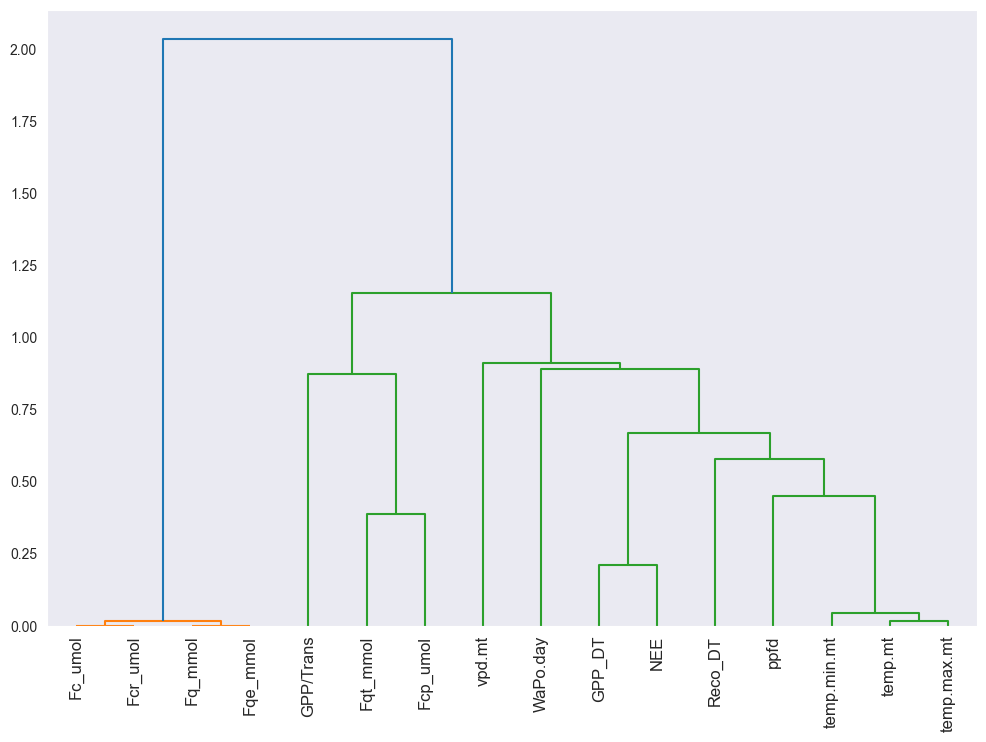

In [233]:
utils.dispaly_cluster_dendrogram(df)

In [251]:
target = 'GPP_DT'
_ = df.copy()
_ = df.dropna(subset=target)
y = _[target]
X = _.drop(columns=targets.columns.to_list())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, shuffle=True, random_state=42)

model = xgb.XGBRegressor(n_estimators=2500, 
                         max_depth=4, 
                         learning_rate=.03, gamma=14, 
                         early_stopping_rounds=50, 
                         min_child_weight=3, 
                         colsample_bytree=1, 
                         subsample=.5, 
                         eval_metric=root_mean_squared_error)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:2.89129	validation_0-root_mean_squared_error:2.89129
[1]	validation_0-rmse:2.84502	validation_0-root_mean_squared_error:2.84502
[2]	validation_0-rmse:2.80091	validation_0-root_mean_squared_error:2.80091
[3]	validation_0-rmse:2.75873	validation_0-root_mean_squared_error:2.75873
[4]	validation_0-rmse:2.71836	validation_0-root_mean_squared_error:2.71836
[5]	validation_0-rmse:2.67886	validation_0-root_mean_squared_error:2.67886
[6]	validation_0-rmse:2.64108	validation_0-root_mean_squared_error:2.64108
[7]	validation_0-rmse:2.60644	validation_0-root_mean_squared_error:2.60644
[8]	validation_0-rmse:2.57058	validation_0-root_mean_squared_error:2.57058
[9]	validation_0-rmse:2.53484	validation_0-root_mean_squared_error:2.53484
[10]	validation_0-rmse:2.50000	validation_0-root_mean_squared_error:2.50000
[11]	validation_0-rmse:2.46970	validation_0-root_mean_squared_error:2.46970
[12]	validation_0-rmse:2.43908	validation_0-root_mean_squared_error:2.43908
[13]	validation_0-rmse

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,1
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from

In [252]:
r2_score(y_test, model.predict(X_test))

0.6120319363589913

In [253]:
# explainer = shap.KernelExplainer(
#     model.predict,
#     shap.kmeans(X_train, 10)
#     )
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

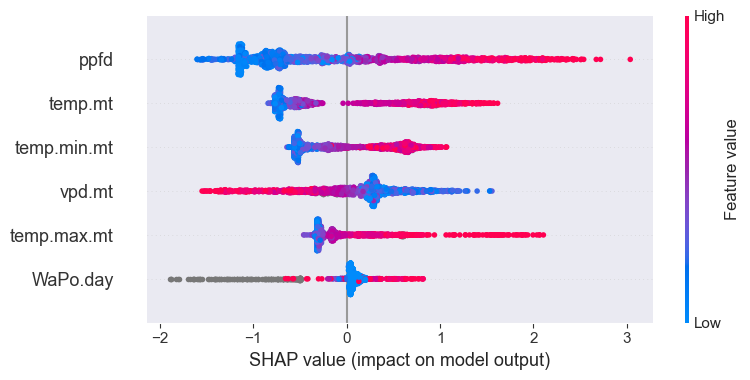

In [254]:
shap.summary_plot(shap_values, X_train, plot_type="dot")

In [255]:
shap_values_doy = pd.DataFrame(shap_values).groupby(X_train.index.day_of_year).mean().to_numpy()
features_doy = features.groupby(features.index.day_of_year).mean()
targets_doy = targets.groupby(pd.to_datetime(targets.index).day_of_year).mean()

In [256]:
sorted = pd.DataFrame(shap_values_doy, columns=features_doy.columns).mean().sort_values().index.to_list()

In [257]:
shap_melt = pd.DataFrame(shap_values_doy, columns=features_doy.columns).melt(ignore_index=False)

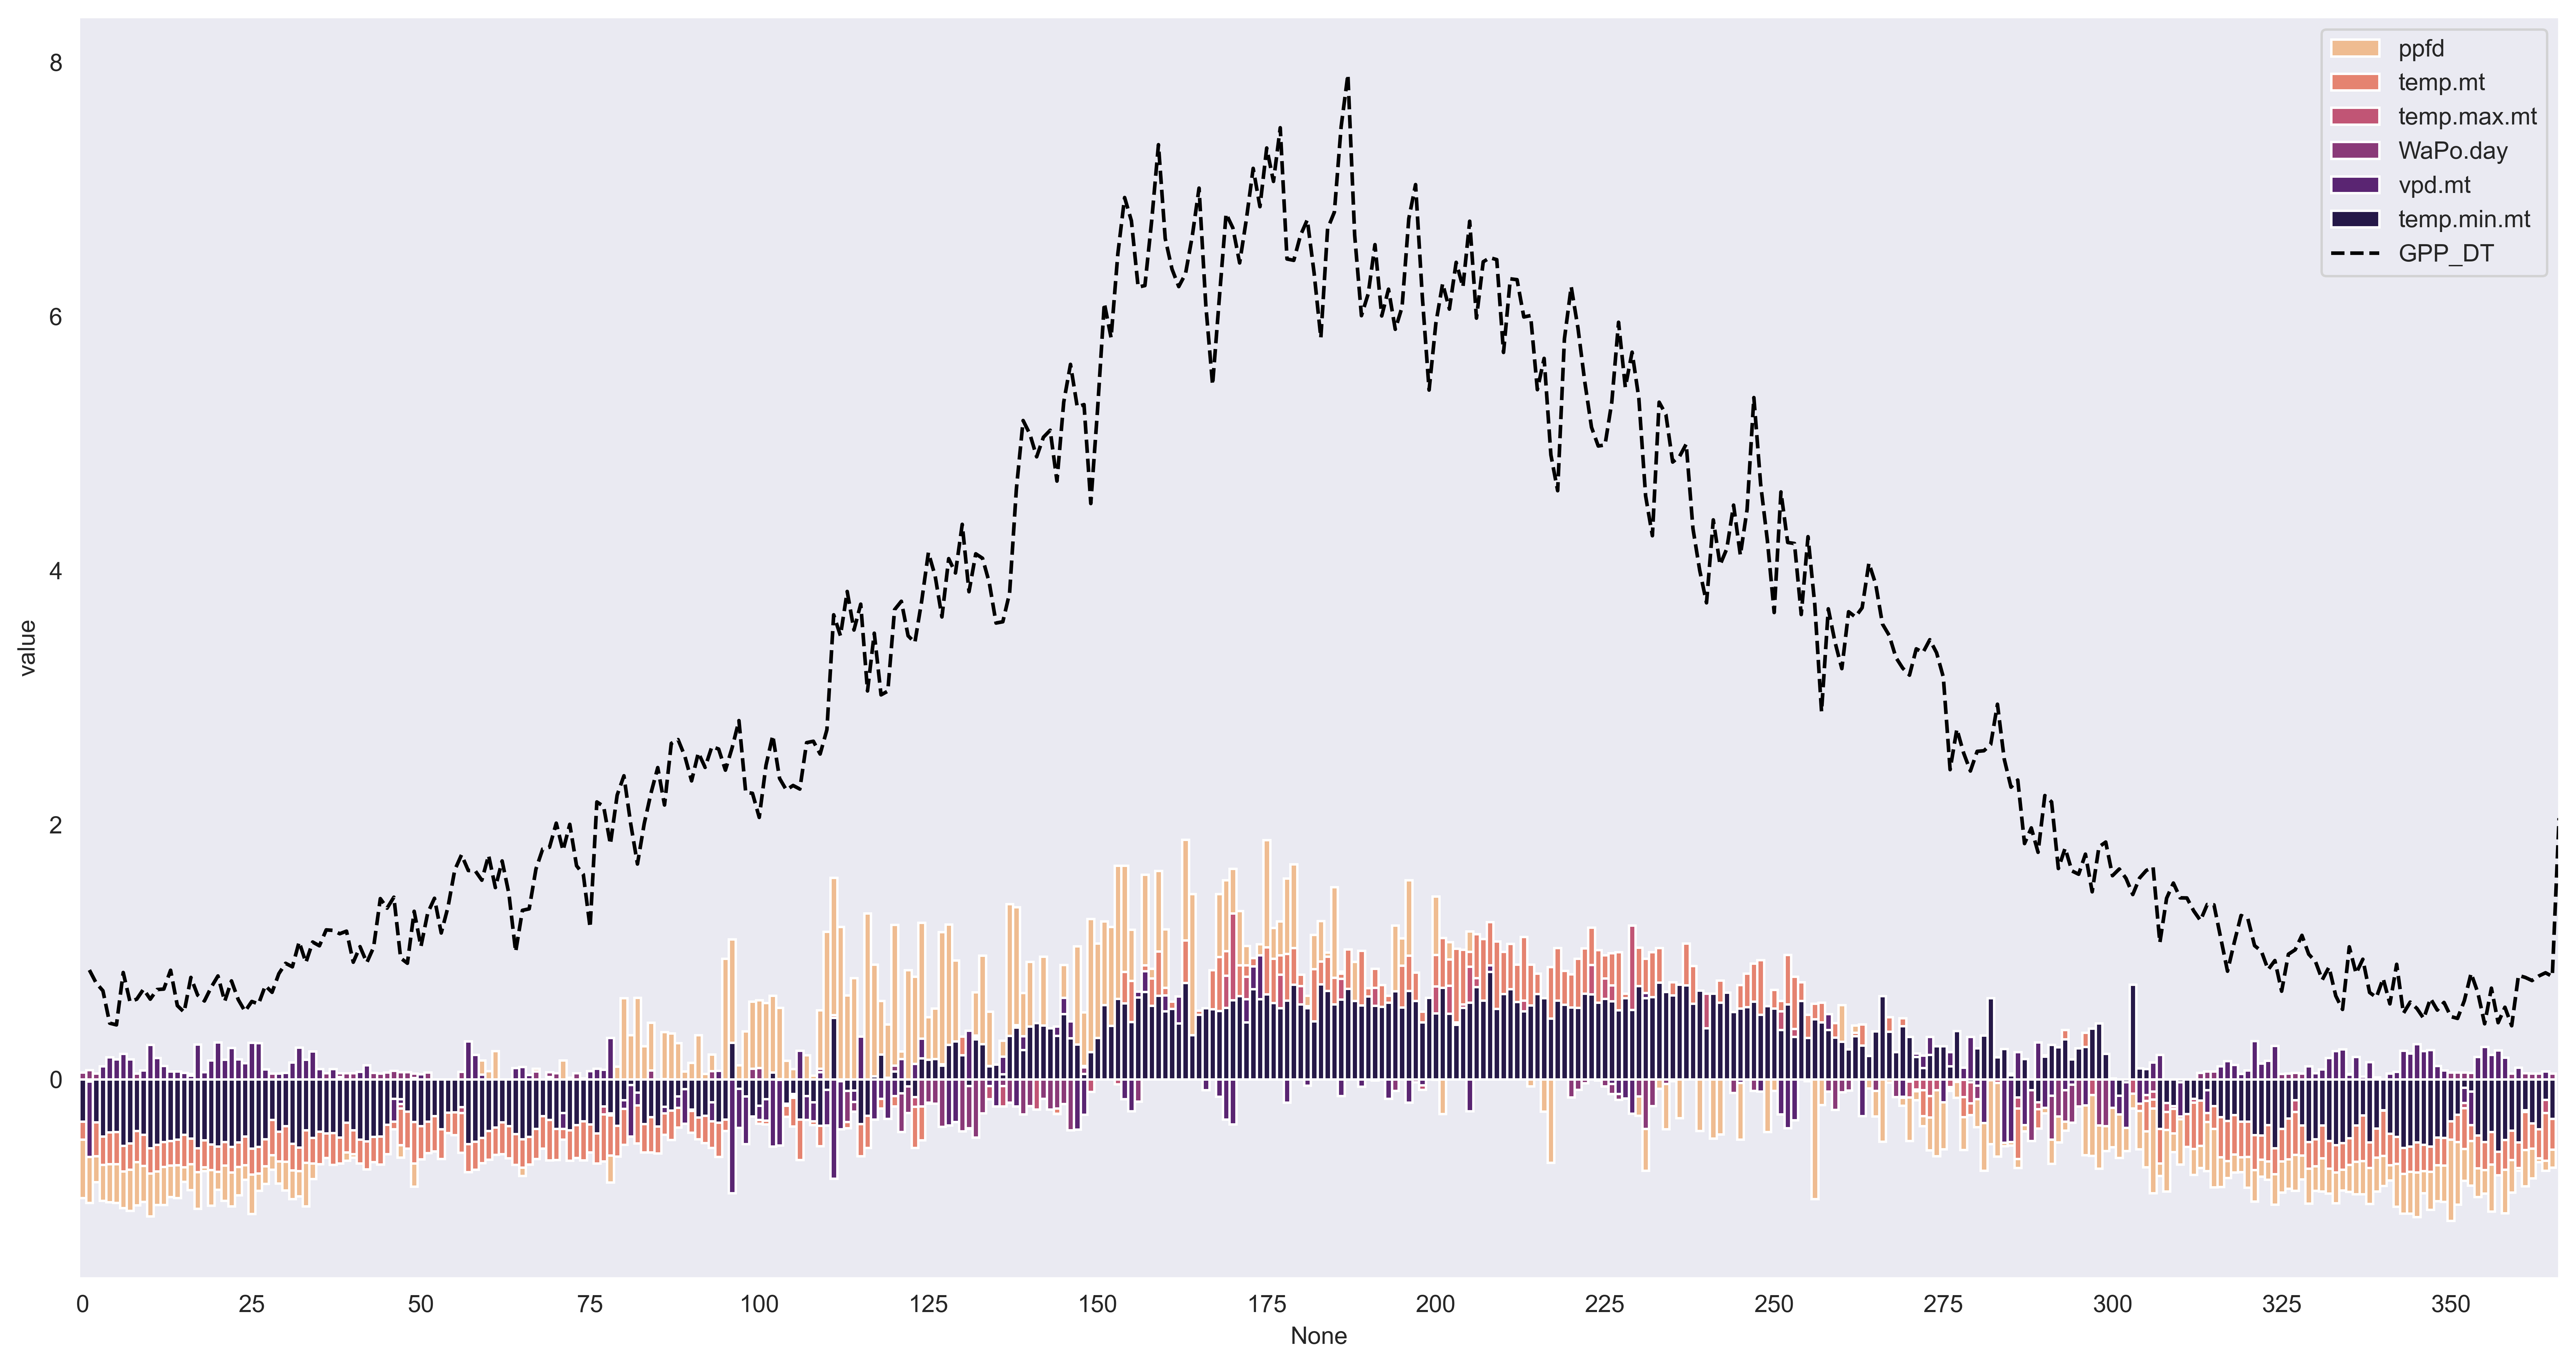

In [261]:
fig, ax = plt.subplots(1,1, figsize=(15,8), dpi=500)
sns.barplot(data=shap_melt, x=shap_melt.index, y='value', hue='variable', dodge=False, palette='magma_r', fill=True, gap=0, width=1, hue_order=sorted, alpha=1)
plt.plot(targets_doy[target], label=target, color='black', linestyle='--')
ticks = ax.set_xticks(list(np.arange(0,375,25)))
ticks_lab = ax.set_xticklabels(list(np.arange(0,375,25)))
plt.margins(x=0)
sns.set_style('dark')
plt.tight_layout()
plt.legend()


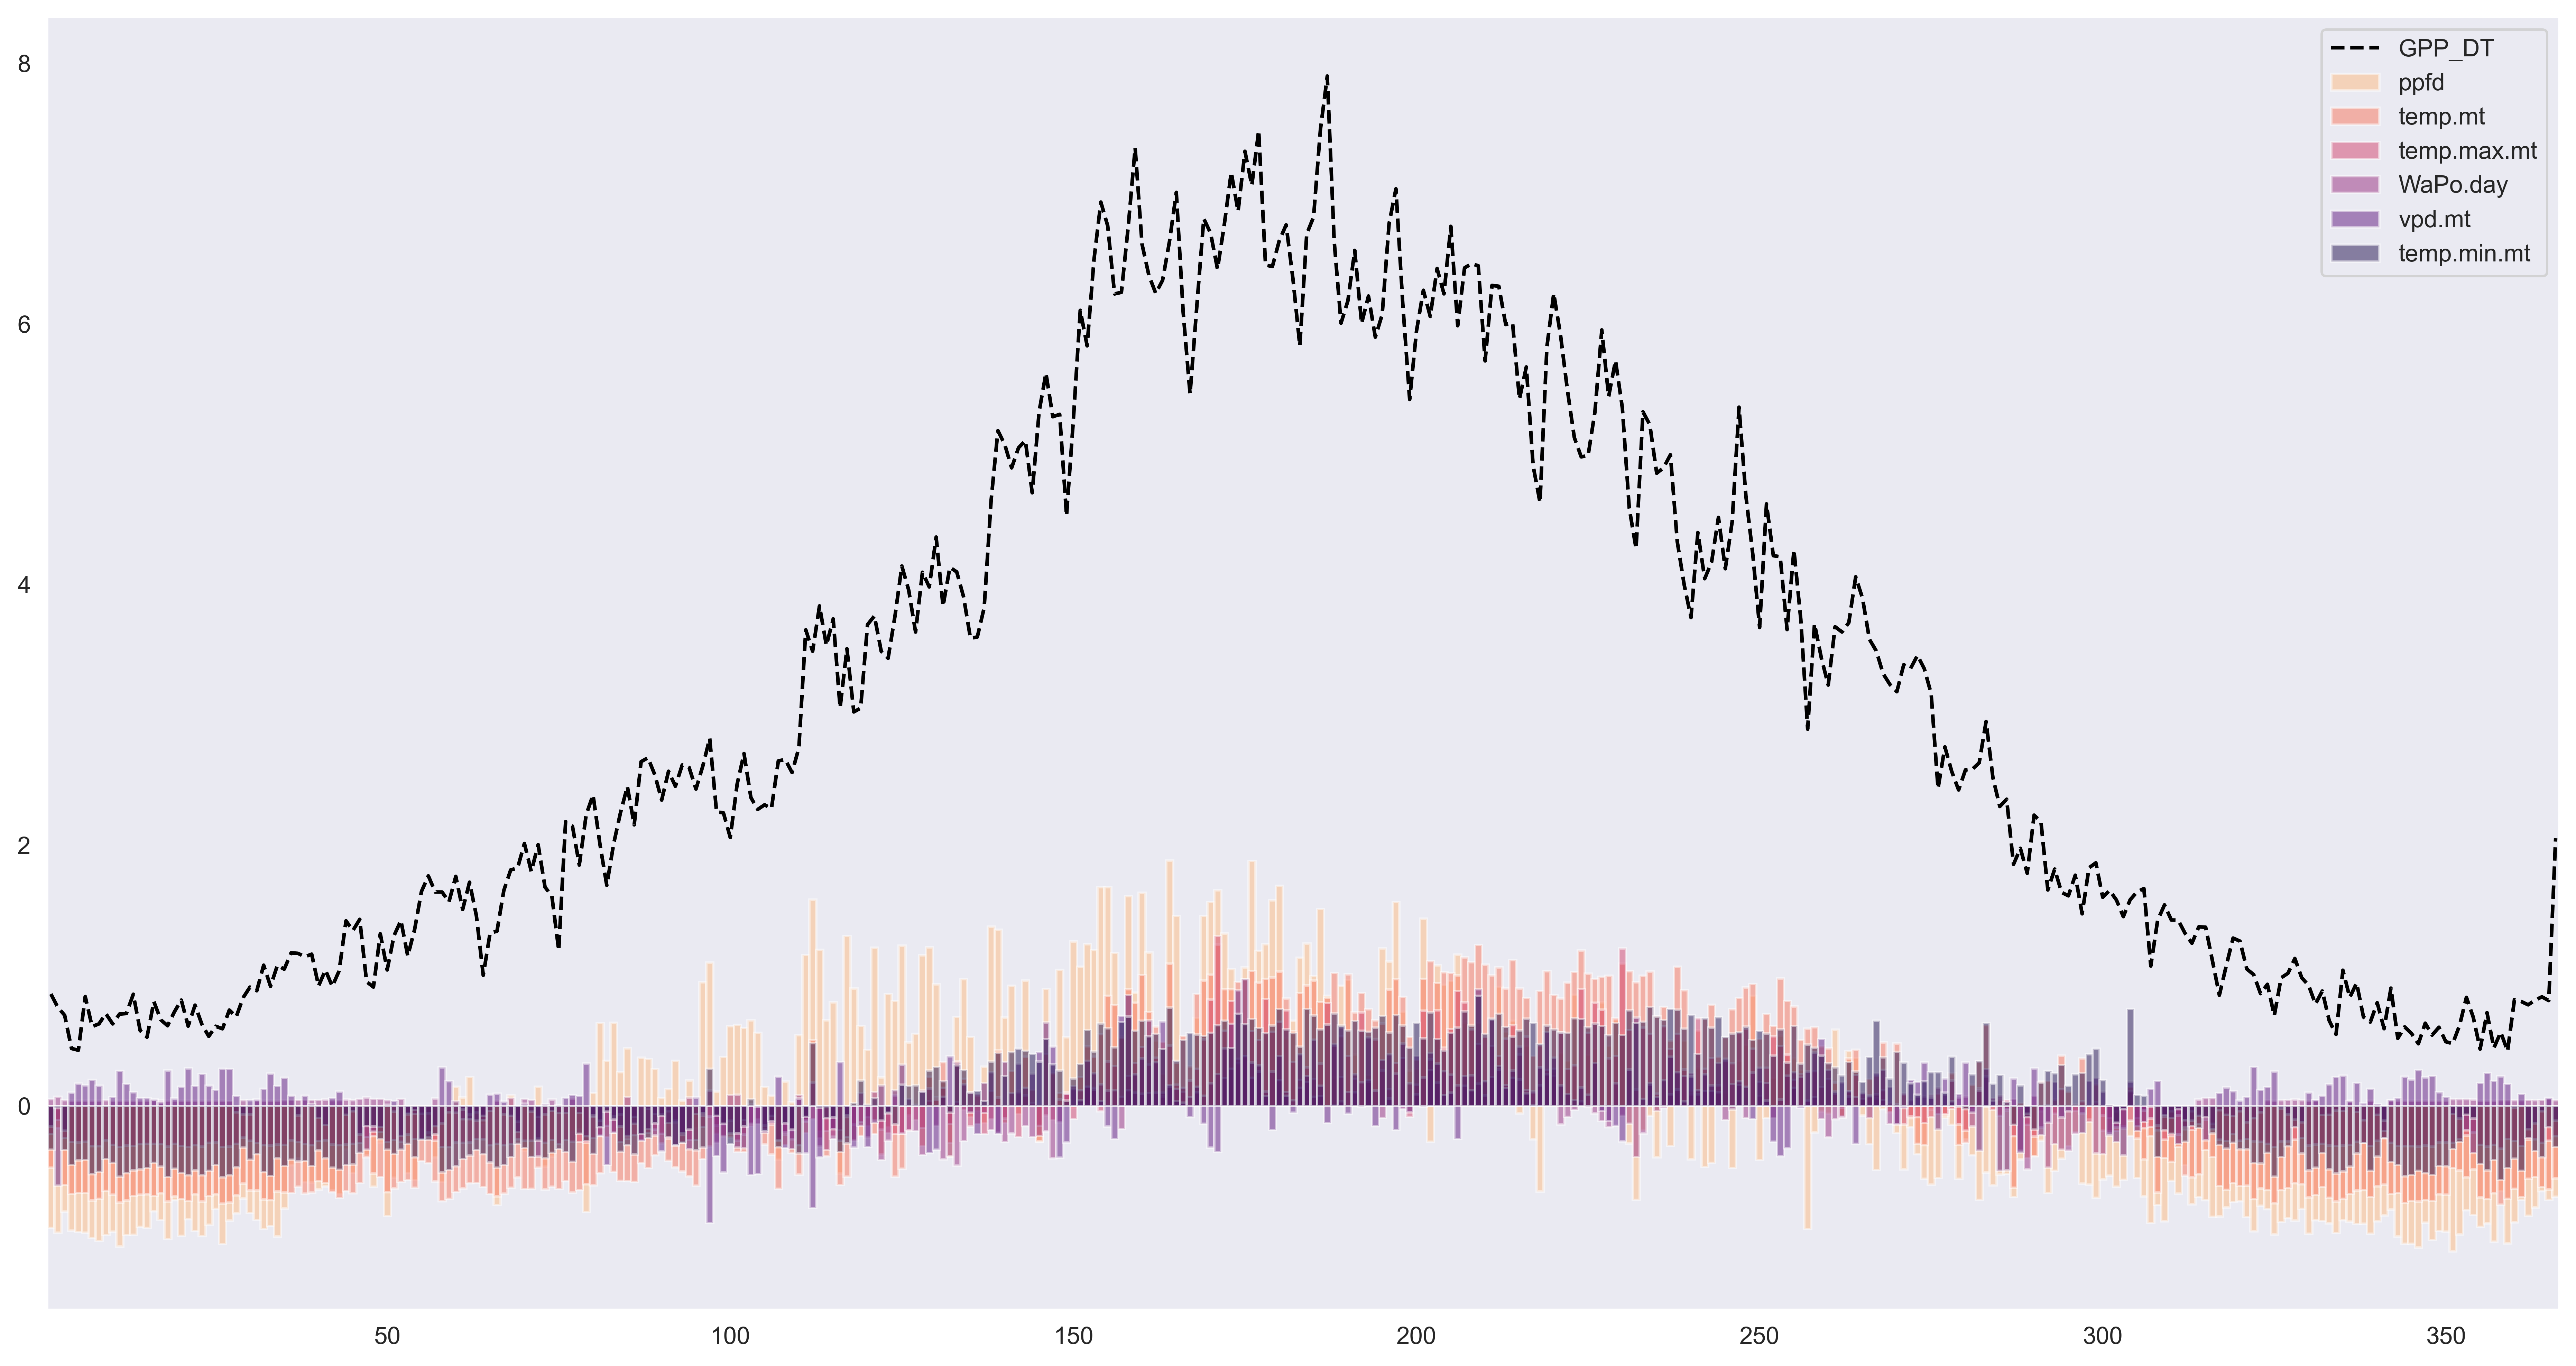

In [113]:
fig, ax = plt.subplots(1,1, figsize=(15,8), dpi=500)
i=0
for variable in sorted:
    plt.bar(features_doy.index, shap_melt[shap_melt["variable"]==variable].value, label=variable, color=sns.color_palette("magma_r")[i], width=1, alpha=.5)
    i += 1
plt.plot(targets_doy[target], label=target, color='black', linestyle='--')
plt.margins(x=0)
plt.tight_layout()
plt.legend()


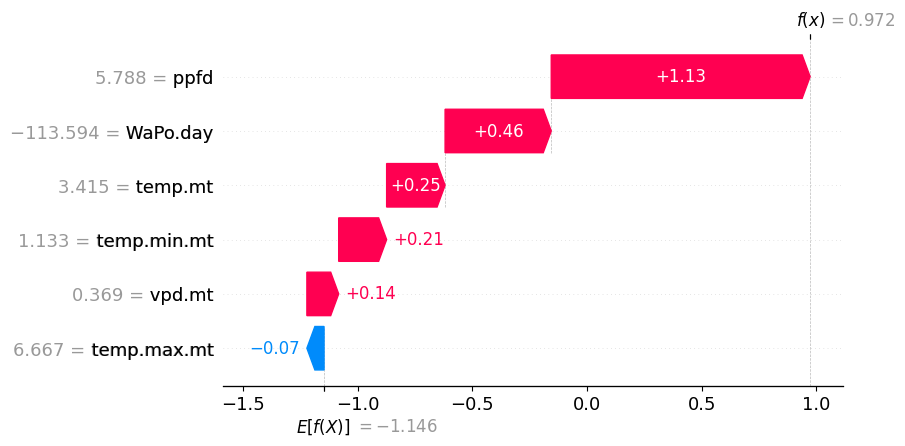

In [94]:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_doy[365, :],
        base_values=explainer.expected_value,
        data=features_doy.iloc[365, :],
        feature_names=features_doy.columns
    )
)

<BarContainer object of 6 artists>

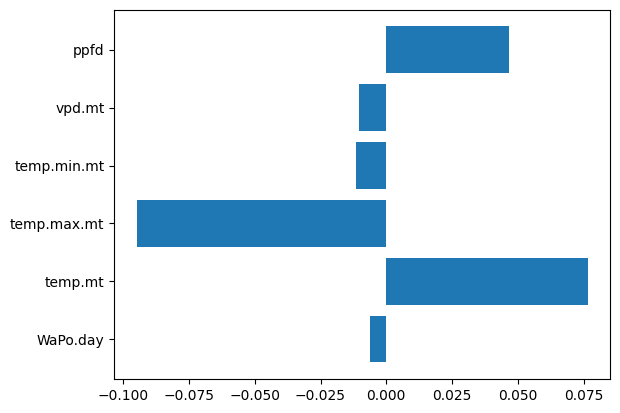

In [10]:
plt.barh(list(X_train.columns), shap_values.mean(axis=0))

In [15]:
rfecv = RFECV(model, min_features_to_select=1, cv=5)
rfecv.fit(X_train, y_train)

,estimator estimator: ``Estimator`` instanceA supervised learning estimator with a ``fit`` method that providesinformation about feature importance either through a ``coef_``attribute or through a ``feature_importances_`` attribute.,"XGBRegressor(...ree=None, ...)"
,"step step: int or float, default=1If greater than or equal to 1, then ``step`` corresponds to the(integer) number of features to remove at each iteration.If within (0.0, 1.0), then ``step`` corresponds to the percentage(rounded down) of features to remove at each iteration.Note that the last iteration may remove fewer than ``step`` features inorder to reach ``min_features_to_select``.",1
,"min_features_to_select min_features_to_select: int, default=1The minimum number of features to be selected. This number of featureswill always be scored, even if the difference between the originalfeature count and ``min_features_to_select`` isn't divisible by``step``... versionadded:: 0.20",1
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If theestimator is not a classifier or if ``y`` is neither binary nor multiclass,:class:`~sklearn.model_selection.KFold` is used.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value of None changed from 3-fold to 5-fold.",5
,"scoring scoring: str or callable, default=NoneScoring method to evaluate the :class:`RFE` selectors' performance. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.",None
,"verbose verbose: int, default=0Controls verbosity of output.",0
,"n_jobs n_jobs: int or None, default=NoneNumber of cores to run in parallel while fitting across folds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a `coef_`or `feature_importances_` attributes of estimator.Also accepts a string that specifies an attribute name/pathfor extracting feature importance.For example, give `regressor_.coef_` in case of:class:`~sklearn.compose.TransformedTargetRegressor` or`named_steps.clf.feature_importances_` in case of:class:`~sklearn.pipeline.Pipeline` with its last step named `clf`.If `callable`, overrides the default feature importance getter.The callable is passed with the fitted estimator and it shouldreturn importance for each feature... versionadded:: 0.24",'auto'
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None


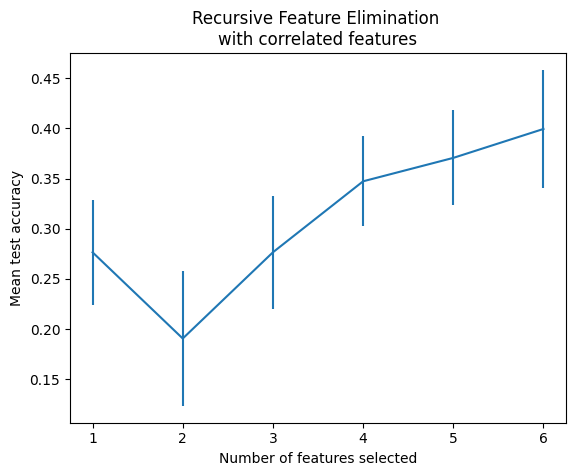

In [18]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [16]:
X_train.columns[rfecv.support_]

Index(['WaPo.day', 'temp.mt', 'temp.max.mt', 'temp.min.mt', 'vpd.mt', 'ppfd'], dtype='str')

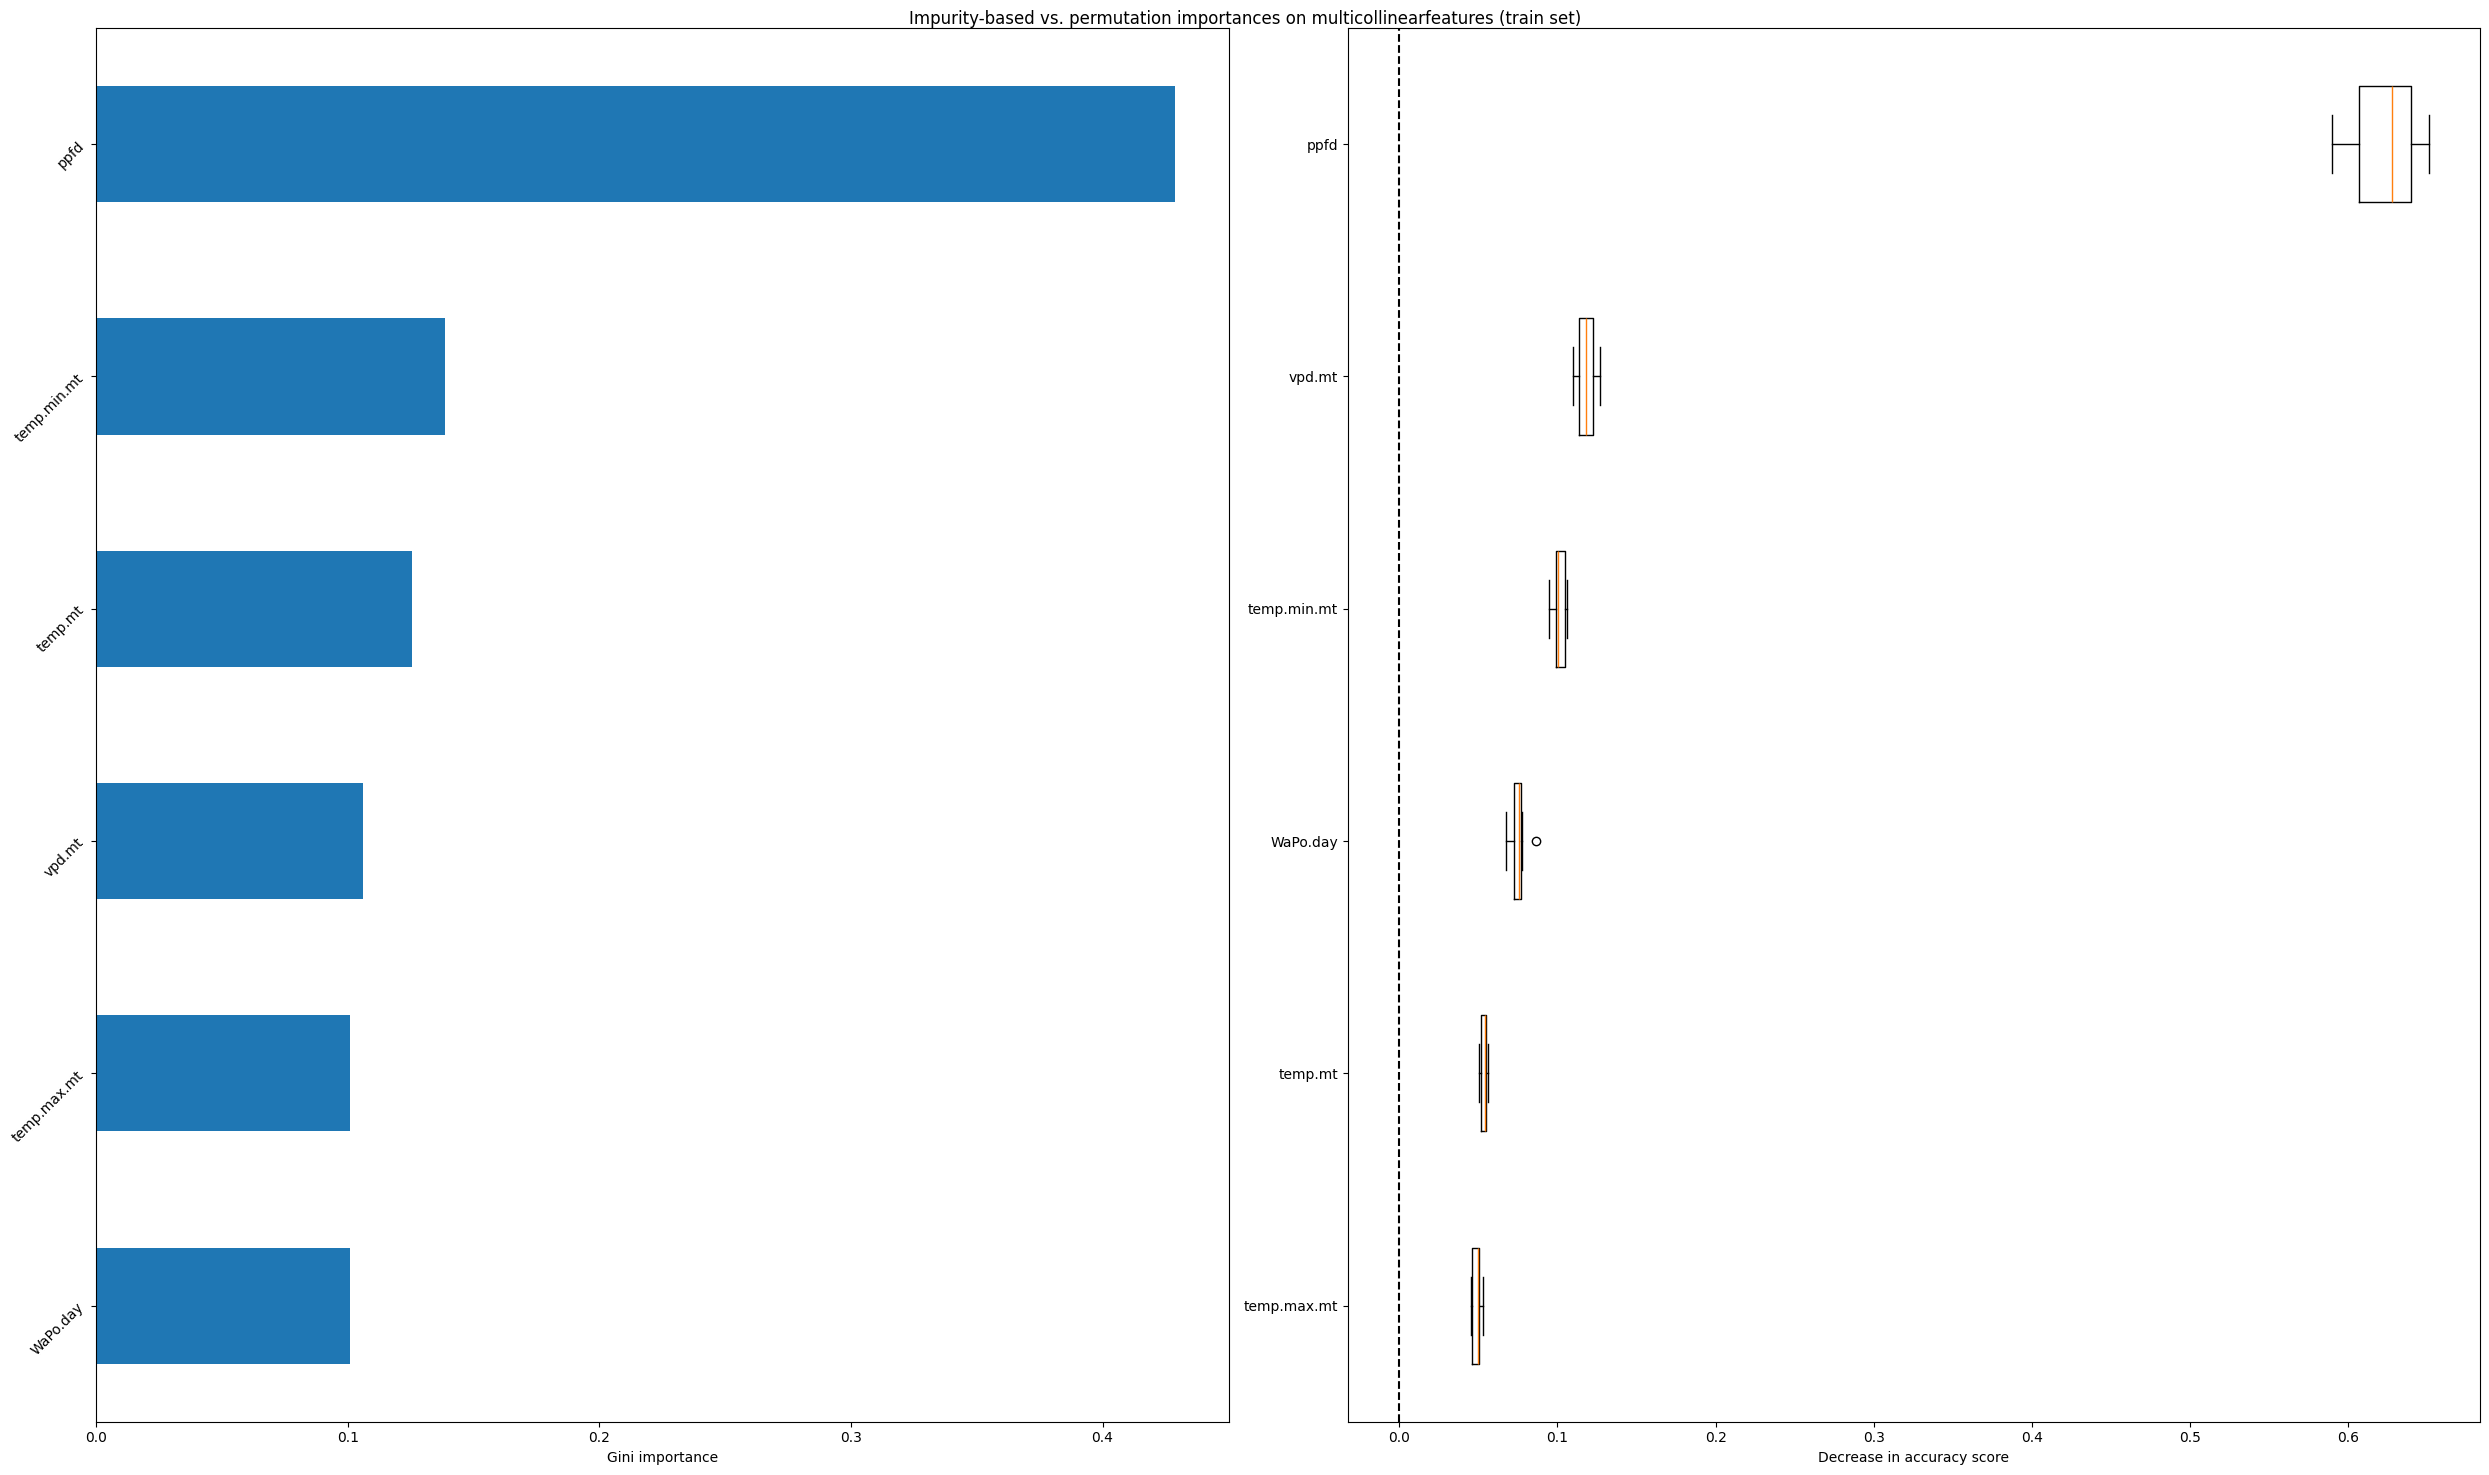

In [11]:
utils.plot_gini_permutation_importance(model, X_train, y_train)